In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [3]:
train_df = pd.read_csv("../input/google-machine-learning-crash-course/california_housing_train (5).xls")
test_df = pd.read_csv("../input/google-machine-learning-crash-course/california_housing_test (2).csv")

# Shuffling the data
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [4]:
# Convert raw value to their Z-score
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [5]:
# This cell code creates feature layer constaining three features
feature_columns = []

# resolution in Z's
resolution_in_Zs = 0.3

# Create a bucket feature column for latitude
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm["latitude"])),
                                     int(max(train_df_norm["latitude"])),
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm["longitude"])),
                                      int(max(train_df_norm["longitude"])),
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# Create feature cross of latitude and longitude
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Represent median_income and population as floting point value
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert these feature columns into a layer
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

**Build a Linear Regression model as a baseline**

In [6]:
# Define the plotting function (loss vs epoch)
def plot_the_loss_curve(epochs, mse):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    
    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max()*1.03])
    plt.show()
    

In [7]:
# # Define functions to create and train a linear regression model
# def create_model(my_learning_rate, feature_layer):
#     model = tf.keras.models.Sequential()
#     model.add(feature_layer)
    
#     model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    
#     model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
#                   loss="mean_squared_error",
#                   metrics=[tf.keras.metrics.MeanSquaredError()])
    
#     return model

# def train_model(model, dataset, epochs, batch_size, label_name):
#     features = {name:np.array(value) for name, value in dataset.items()}
#     label = np.array(features.pop(label_name))
#     history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)
    
#     epochs = history.epoch
#     hist = pd.DataFrame(history.history)
#     rmse = hist["mean_squared_error"]
    
#     return epochs, rmse


In [8]:
# # Calling the above functions
# learning_rate = 0.01
# epochs = 15
# batch_size = 1000
# label_name = "median_house_value"

# my_model = create_model(learning_rate, my_feature_layer)

# epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
# plot_the_loss_curve(epochs, mse)

# test_features = {name:np.array(value) for name,value in test_df_norm.items()}
# test_label = np.array(test_features.pop(label_name))
# # Evaluate the linear regression model
# my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

**Define a deep neural net model**

In [9]:
def create_model(my_learning_rate, my_feature_layer):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    
    # Define 1st hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=10, activation='relu', name='Hidden1'))
    
    # Sim. define hidden layer 2 and the output layer
    model.add(tf.keras.layers.Dense(units=6, activation='relu', name='Hidden2'))
    
    model.add(tf.keras.layers.Dense(units=1, name='Output'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model


In [10]:
# training function
def train_model(model, dataset, epochs, label_name, batch_size=None):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]
    
    return epochs, mse

2022-02-17 18:49:51.750258: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-17 18:49:51.898189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
17/17 [==============================] - 1s 4ms/step - loss: 0.8235 - mean_squared_error: 0.8235
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4204 - mean_squared_error: 0.4204
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3527 - mean_squared_error: 0.3527
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3425 - mean_squared_error: 0.3425
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3393 - mean_squared_error: 0.3393
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3374 - mean_squared_error: 0.3374
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3363 - mean_squared_error: 0.3363
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3351 - mean_squared_error: 0.3351
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3340 - mean_squared_error: 0.3340
Epoch 10/20
17/17 [=========

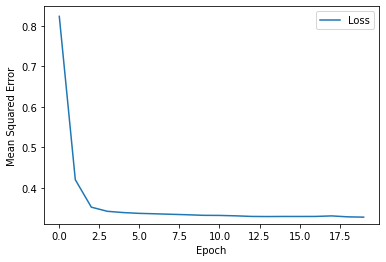

3/3 [==============================] - 0s 11ms/step - loss: 0.3684 - mean_squared_error: 0.3684


[0.36842676997184753, 0.36842676997184753]

In [11]:
# Calling the above functions to build and train the model
learning_rate = 0.01
epochs = 20
batch_size = 1000
label_name = "median_house_value"

my_model = create_model(learning_rate, my_feature_layer)

epochs, mse = train_model(my_model, train_df_norm, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name,value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name))
# Evaluate the new model
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)